# Линейная регрессия

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt

In C:\Users\Sandra\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\Sandra\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\Sandra\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
data=pd.read_csv('data/botswana.tsv', sep='\t')
data.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle
0,0,18,10,catholic,4.0,1.0,1.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
1,2,43,11,protestant,2.0,1.0,1.0,1,20.0,14.0,1,1.0,1.0,1.0,1.0
2,0,49,4,spirit,4.0,1.0,0.0,1,22.0,1.0,1,1.0,1.0,0.0,0.0
3,0,24,12,other,2.0,1.0,0.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
4,3,32,13,other,3.0,1.0,1.0,1,24.0,12.0,1,1.0,1.0,1.0,1.0


Датасет содержит данные опроса 4361 женщины из Ботсваны.

О каждой из них мы знаем:

* сколько детей она родила (ceb);
* возраст (age);
* длительность получения образования (educ);
* религиозная принадлежность (religion);
* идеальное, по её мнению, количество детей в семье (idlnchld);
* была ли она когда-нибудь замужем (evermarr);
* возраст первого замужества (agefm);
* длительность получения образования мужем (heduc);
* знает ли она о методах контрацепции (knowmeth);
* использует ли она методы контрацепции (usemeth);
* живёт ли она в городе (urban);
* есть ли у неё электричество, радио, телевизор и велосипед (electric, radio, tv, bicycle).

In [3]:
data.religion.value_counts()

spirit        1841
other         1080
protestant     993
catholic       447
Name: religion, dtype: int64

In [4]:
data.isnull().sum()

ceb            0
age            0
educ           0
religion       0
idlnchld     120
knowmeth       7
usemeth       71
evermarr       0
agefm       2282
heduc       2405
urban          0
electric       3
radio          2
tv             2
bicycle        3
dtype: int64

In [5]:
data.dropna().shape

(1834, 15)

Видно, что в наших данных много пропусков, если их просто удалять, то останется 1834 объекта из 4361. Такой способ работы с пропущенными значениями является плохим, пропущенные значения для разных признаков обрабатываются по-разному.

Начнем с признака _'agefm'_. Можно заметить, что пропущенные значения в нем возникают в том случае, если женщина никогда не выходила замуж, то есть если соответсвующее значение _'evermarr'_ равно $0$. Получается, что данный признак $x_1$ на части объектов в принципе не может принимать какие-либо значения, поэтому нужно создать новый бинарный признак $x_2$:
$$x_2=\begin{cases}
1 &\text{, если $x_1$=NaN}\\
0 &\text{, если $x_1$ принимает какое-либо значение.}
\end{cases}$$

Таким образом, создадим признак _'nevermarr'_, в котором $1$ соответствует пропуску в _'agefm'_. Признак _'evermarr'_ теперь может быть удален совсем для избежания мультиколлинеарности, а пропущенные значения в _'agefm'_ заменены на константу.

In [6]:
data['nevermarr']=data['agefm'].apply(lambda x: 1 if np.isnan(x) else 0)
data.drop('evermarr', axis=1, inplace=True)
data['agefm'].fillna(0, inplace=True)
data.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr
0,0,18,10,catholic,4.0,1.0,1.0,0.0,NaN,1,1.0,1.0,1.0,1.0,1
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0
3,0,24,12,other,2.0,1.0,0.0,0.0,NaN,1,1.0,1.0,1.0,1.0,1
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0


In [7]:
data.heduc.unique()

array([nan, 14.,  1., 12.,  7., 11.,  9., 17.,  3., 16., 10., 15.,  0.,
       13.,  8.,  4.,  6., 20.,  5.,  2., 19., 18.])

Теперь можно обработать пропущенные значения в _'heduc'_ - заменим их на $-1$ там, где _'nevermarr'_ равно $1$ ($0$ уже встречается среди значений этого признака, поэтому его использовать нельзя).

In [8]:
data.heduc=data.apply(lambda row: -1 if row['nevermarr']==1 else row['heduc'], axis=1)

In [9]:
data.heduc.isnull().sum()

123

Видим, что мы обработали не все пропуски в _'heduc'_. Также много пропусков содержится в столбцах _'idlnchld'_ и _'usemeth'_. Их стоит обработать как и в предыдущем случае - с помощью дополнительных столбцов-индикаторов, так как они тоже являются категориальными признаками. 

Столбцы _'knowmeth'_, _'electric'_, _'radio'_, _'tv'_, _'bycycle'_ содержат мало пропусков по сравнению с общим количеством ответов, поэтому объекты с пропущенными значениями в этих признаках можно просто удалить.

In [10]:
data['heduc_noans']=data.heduc.apply(lambda x: 1 if np.isnan(x) else 0)
data['idlnchld_noans']=data.idlnchld.apply(lambda x: 1 if np.isnan(x) else 0)
data['usemeth_noans']=data.usemeth.apply(lambda x: 1 if np.isnan(x) else 0)

In [11]:
data.heduc=data.apply(lambda row: -2 if row['heduc_noans']==1 else row['heduc'], axis=1)
data.idlnchld=data.apply(lambda row: -1 if row['idlnchld_noans']==1 else row['idlnchld'], axis=1)
data.usemeth=data.apply(lambda row: -1 if row['usemeth_noans']==1 else row['usemeth'], axis=1)

In [12]:
data.dropna(inplace=True,axis=0)

Этап предобработки данных завершен, теперь можно переходить непосредственно к построению модели.

In [13]:
data.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr,heduc_noans,idlnchld_noans,usemeth_noans
0,0,18,10,catholic,4.0,1.0,1.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1,0,0,0
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0,0,0,0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0,0,0,0
3,0,24,12,other,2.0,1.0,0.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1,0,0,0
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0,0,0,0


In [14]:
linregr_full=smf.ols('ceb ~ age+educ+religion+idlnchld+knowmeth+usemeth+agefm+heduc+urban+electric+radio'\
            '+tv+bicycle+heduc_noans+idlnchld_noans+usemeth_noans+nevermarr', data)
fitted=linregr_full.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     412.5
Date:                Thu, 15 Oct 2020   Prob (F-statistic):               0.00
Time:                        00:19:15   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.0263      0.212     -4.835      0.000      -1.443      -0.610
religion[T.other]         -0.0830      0.083     -1.001      0.317      -0.245       0.080
religion[T.protestant]    -0.0149      0.082     -0.181      0.857      -0.176       0.146
religion[T.spirit]        -0.0191      0.077     -0.248      0.804      -0.171       0.132
age                        0.1703      0.003     51.891      0.000       0.164       0.177
educ                      -0.0724      0.007     -9.843      0.000      -0.087      -0.058
idlnchld                   0.0760      0.011      6.923      0.000       0.054       0.098
knowmeth                   0.5564      0.121      4.580      0.000       0.318       0.795
usemeth                    0.6473      0.048     13.424      0.000       0.553       0.742
agefm                     -0.0604      0.007     -9.213      0.000      -0.073      -0.048
heduc                     -0.0551      0.008     -6.838      0.000      -0.071      -0.039
urban                     -0.2137      0.047     -4.527      0.000      -0.306      -0.121
electric                  -0.2685      0.077     -3.479      0.001      -0.420      -0.117
radio                     -0.0235      0.051     -0.461      0.645      -0.123       0.076
tv                        -0.1451      0.093     -1.566      0.118      -0.327       0.037
bicycle                    0.2139      0.050      4.260      0.000       0.115       0.312
heduc_noans               -0.8724      0.145     -6.026      0.000      -1.156      -0.589
idlnchld_noans             0.6539      0.153      4.286      0.000       0.355       0.953
usemeth_noans              0.7652      0.196      3.910      0.000       0.382       1.149
nevermarr                 -2.2393      0.148    -15.143      0.000      -2.529      -1.949
==============================================================================
Omnibus:                      224.411   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              859.014
Skew:                           0.003   Prob(JB):                    2.93e-187
Kurtosis:                       5.178   Cond. No.                         361.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Коэффициент детерминации нашей модели равен 0.644, что достаточно неплохо. Однако этого недостаточно, чтобы понять качество нашей модели. 

С помощью критерия Бройша-Пагана посмотрим, выполняется ли гипотеза о гомоскедастичности ошибок. 

$H_0$: ошибки гомоскедастичны, то есть их дисперсия не меняется в зависимости от значений признаков.

$H_1$: ошибки гетероскедастичны.

In [15]:
print('p-value критерия Бройша-Пагана: ', sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1])

p-value критерия Бройша-Пагана:  1.1452927633437192e-225


Достигаемый уровень значимости очень мал, что опровергает нашу нулевую гипотезу.

Это легко подтверждается с помощью визуализации зависимости ошибок, например, от возраста. Видно, что ошибки распределены не равномерной полосой, а расширяющейся к правому краю.

Text(0.5, 0, 'Age')

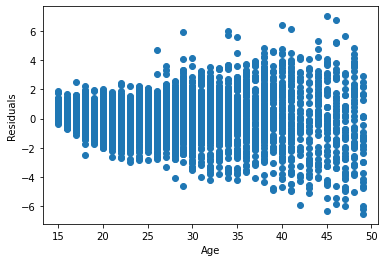

In [16]:
plt.scatter(data.age,fitted.resid)
plt.ylabel('Residuals')
plt.xlabel('Age')

Так как ошибки гетероскедастичны, то для улучшения модели можно воспользоваться поправкой Уайта.

In [17]:
fitted=linregr_full.fit(cov_type='HC1')
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     345.0
Date:                Thu, 15 Oct 2020   Prob (F-statistic):               0.00
Time:                        00:19:15   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:                  HC1                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.0263      0.266     -3.863      0.000      -1.547      -0.506
religion[T.other]         -0.0830      0.078     -1.067      0.286      -0.235       0.069
religion[T.protestant]    -0.0149      0.078     -0.192      0.848      -0.167       0.137
religion[T.spirit]        -0.0191      0.071     -0.268      0.789      -0.159       0.121
age                        0.1703      0.004     38.627      0.000       0.162       0.179
educ                      -0.0724      0.007     -9.924      0.000      -0.087      -0.058
idlnchld                   0.0760      0.015      5.236      0.000       0.048       0.104
knowmeth                   0.5564      0.174      3.190      0.001       0.215       0.898
usemeth                    0.6473      0.052     12.478      0.000       0.546       0.749
agefm                     -0.0604      0.010     -6.174      0.000      -0.080      -0.041
heduc                     -0.0551      0.009     -6.126      0.000      -0.073      -0.037
urban                     -0.2137      0.046     -4.667      0.000      -0.303      -0.124
electric                  -0.2685      0.072     -3.732      0.000      -0.410      -0.128
radio                     -0.0235      0.053     -0.446      0.656      -0.127       0.080
tv                        -0.1451      0.082     -1.766      0.077      -0.306       0.016
bicycle                    0.2139      0.048      4.412      0.000       0.119       0.309
heduc_noans               -0.8724      0.191     -4.556      0.000      -1.248      -0.497
idlnchld_noans             0.6539      0.216      3.029      0.002       0.231       1.077
usemeth_noans              0.7652      0.213      3.590      0.000       0.347       1.183
nevermarr                 -2.2393      0.202    -11.082      0.000      -2.635      -1.843
==============================================================================
Omnibus:                      224.411   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              859.014
Skew:                           0.003   Prob(JB):                    2.93e-187
Kurtosis:                       5.178   Cond. No.                         361.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

По полученным достигаемым уровням значимости критерия Стьюдента для значимости коэффициентов видно, что незначимыми признаками являются _'religion'_, _'radio'_ и _'tv'_. На этом основании удалим их из нашей первоначальной модели.

In [18]:
linregr_short=smf.ols('ceb ~ age+educ+idlnchld+knowmeth+usemeth+agefm+heduc+urban+electric'\
            '+bicycle+heduc_noans+idlnchld_noans+usemeth_noans+nevermarr', data)
fitted_short=linregr_short.fit()
fitted_short.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     559.5
Date:                Thu, 15 Oct 2020   Prob (F-statistic):               0.00
Time:                        00:19:15   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.198     -5.393      0.000      -1.459      -0.681
age                0.1702      0.003     52.271      0.000       0.164       0.177
educ              -0.0729      0.007    -10.285      0.000      -0.087      -0.059
idlnchld           0.0770      0.011      7.042      0.000       0.056       0.098
knowmeth           0.5610      0.121      4.628      0.000       0.323       0.799
usemeth            0.6516      0.048     13.537      0.000       0.557       0.746
agefm             -0.0606      0.007     -9.240      0.000      -0.073      -0.048
heduc             -0.0573      0.008     -7.186      0.000      -0.073      -0.042
urban             -0.2190      0.047     -4.682      0.000      -0.311      -0.127
electric          -0.3207      0.070     -4.584      0.000      -0.458      -0.184
bicycle            0.2046      0.049      4.154      0.000       0.108       0.301
heduc_noans       -0.8853      0.145     -6.122      0.000      -1.169      -0.602
idlnchld_noans     0.6565      0.152      4.310      0.000       0.358       0.955
usemeth_noans      0.7732      0.196      3.955      0.000       0.390       1.156
nevermarr         -2.2501      0.148    -15.231      0.000      -2.540      -1.961
==============================================================================
Omnibus:                      224.096   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              856.760
Skew:                           0.004   Prob(JB):                    9.06e-187
Kurtosis:                       5.175   Cond. No.                         345.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
print('p-value критерия Бройша-Пагана: ', sms.het_breuschpagan(fitted_short.resid, fitted_short.model.exog)[1])

p-value критерия Бройша-Пагана:  1.119745889653916e-228


Дисперсия ошибок по-прежнему непостоянна. Снова воспользуемся поправкой Уайта.

In [20]:
fitted_short=linregr_short.fit(cov_type='HC1')
fitted_short.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     463.4
Date:                Thu, 15 Oct 2020   Prob (F-statistic):               0.00
Time:                        00:19:15   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.258     -4.152      0.000      -1.575      -0.565
age                0.1702      0.004     38.746      0.000       0.162       0.179
educ              -0.0729      0.007    -10.311      0.000      -0.087      -0.059
idlnchld           0.0770      0.014      5.323      0.000       0.049       0.105
knowmeth           0.5610      0.174      3.224      0.001       0.220       0.902
usemeth            0.6516      0.052     12.571      0.000       0.550       0.753
agefm             -0.0606      0.010     -6.192      0.000      -0.080      -0.041
heduc             -0.0573      0.009     -6.440      0.000      -0.075      -0.040
urban             -0.2190      0.045     -4.814      0.000      -0.308      -0.130
electric          -0.3207      0.063     -5.076      0.000      -0.445      -0.197
bicycle            0.2046      0.048      4.279      0.000       0.111       0.298
heduc_noans       -0.8853      0.191     -4.638      0.000      -1.259      -0.511
idlnchld_noans     0.6565      0.216      3.043      0.002       0.234       1.079
usemeth_noans      0.7732      0.212      3.639      0.000       0.357       1.190
nevermarr         -2.2501      0.202    -11.158      0.000      -2.645      -1.855
==============================================================================
Omnibus:                      224.096   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              856.760
Skew:                           0.004   Prob(JB):                    9.06e-187
Kurtosis:                       5.175   Cond. No.                         345.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Так как мы удалили некоторые признаки из модели, необходимо проверить, не привело ли это к значимым ухудшениям. Для этого воспользуемся критерием Фишера.

$H_0$: сокращенная модель работает корректно.

$H_1$: модель ухудшилась.

In [21]:
print("F=%f, p=%f, k1=%f" % linregr_full.fit(cov_type='HC1').compare_f_test(linregr_short.fit(cov_type='HC1')))

F=0.919236, p=0.467231, k1=5.000000


C:\Users\Sandra\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:2169: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  InvalidTestWarning)


p-value не позволяет нам отвергнуть нулевую гипотезу - модель не ухудшилась.

In [22]:
linregr_short2=smf.ols('ceb ~ age+educ+idlnchld+knowmeth+agefm+heduc+urban+electric'\
            '+bicycle+heduc_noans+idlnchld_noans+nevermarr', data)
fitted_short2=linregr_short2.fit(cov_type='HC1')
fitted_short2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ceb   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     396.4
Date:                Thu, 15 Oct 2020   Prob (F-statistic):               0.00
Time:                        00:19:15   Log-Likelihood:                -7825.7
No. Observations:                4348   AIC:                         1.568e+04
Df Residuals:                    4335   BIC:                         1.576e+04
Df Model:                          12                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.1931      0.262     -4.562      0.000      -1.706      -0.681
age                0.1776      0.004     41.592      0.000       0.169       0.186
educ              -0.0560      0.007     -7.788      0.000      -0.070      -0.042
idlnchld           0.0705      0.015      4.748      0.000       0.041       0.100
knowmeth           0.8739      0.174      5.029      0.000       0.533       1.214
agefm             -0.0649      0.010     -6.489      0.000      -0.085      -0.045
heduc             -0.0521      0.009     -5.658      0.000      -0.070      -0.034
urban             -0.1866      0.046     -4.019      0.000      -0.278      -0.096
electric          -0.3218      0.065     -4.953      0.000      -0.449      -0.194
bicycle            0.1979      0.048      4.083      0.000       0.103       0.293
heduc_noans       -0.7947      0.195     -4.070      0.000      -1.177      -0.412
idlnchld_noans     0.5266      0.225      2.343      0.019       0.086       0.967
nevermarr         -2.3625      0.205    -11.498      0.000      -2.765      -1.960
==============================================================================
Omnibus:                      250.641   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              936.515
Skew:                          -0.158   Prob(JB):                    4.35e-204
Kurtosis:                       5.251   Cond. No.                         345.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [23]:
print("F=%f, p=%f, k1=%f" % linregr_short.fit(cov_type='HC1').compare_f_test(linregr_short2.fit(cov_type='HC1')))

F=92.890582, p=0.000000, k1=2.000000


C:\Users\Sandra\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:2169: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  InvalidTestWarning)


p-value очень мал, что говорит о том, что при удалении пары признаков _'usemeth'_, _'usemth_noans'_ модель значимо ухудшается.

По полученной на предыдущем шаге модели (linregr_short) можно сделать следующие выводы:

* У женщин, никогда не выходивших замуж, при прочих равных условиях в среднем на 2.3 ребенка меньше (p<0.001, 95% доверительный интервал - [-2.6, -1.9]).
* У женщин, не знающих какое количество детей идеально, в среднем на 
$$\beta_{idlnchld\_noans}+c_{idlnchld}*\beta_{idlnchld}\approx{0.58},\quadгде\quad c_{idlnchld}=-1$$
детей больше.
* С увеличением возраста женщины на 1 год в среднем количество детей увеличивается на 0.17 (p<0.001, 95% доверительный интервал - [0.16, 0.18]).